## Sample的正确性

100


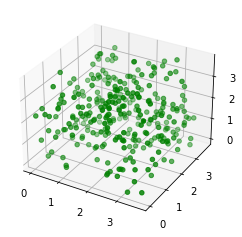

In [144]:
from sampler import Sampler

sampler=Sampler(3,5,0.5)
pos_batch, filted_batch_size = sampler.batch_sample(100)
print(filted_batch_size)

## 画3D散点图
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
pos_batch_flatten=pos_batch.view(-1,3)
x=pos_batch_flatten[:,0]
y=pos_batch_flatten[:,1]
z=pos_batch_flatten[:,2]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c='green', marker='o')
plt.show()

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_3d(system):
    x=system[:,0]
    y=system[:,1]
    z=system[:,2]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c='green', marker='o')
    plt.show()

## 构造随机旋转并验证 Invariance

In [70]:
# ! pip install scipy

In [89]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import torch
quaternion = np.random.rand(4)
quaternion /= np.linalg.norm(quaternion)
print(quaternion.tolist())
r = R.from_quat(quaternion.tolist())
print(r.as_euler('xyz',degrees=True))
matrix=r.as_matrix()
print(matrix)
matrix=torch.FloatTensor(matrix)

[0.4939810074782747, 0.7486731761825873, 0.03476151441029617, 0.44075262521206626]
[141.32580483  38.72743506  99.10414856]
[[-0.12343978  0.7090182   0.69430239]
 [ 0.77030312  0.5095488  -0.38339682]
 [-0.62561628  0.48749688 -0.60905752]]


tensor([0.9312, 0.4426, 1.0948, 1.1040, 0.6782, 1.3597, 0.5871, 0.8161, 0.8781,
        1.4839])


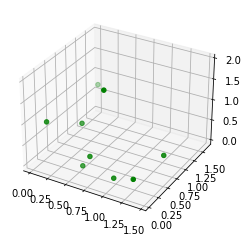

tensor([0.9312, 0.4426, 1.0948, 1.1040, 0.6782, 1.3597, 0.5871, 0.8161, 0.8781,
        1.4839])


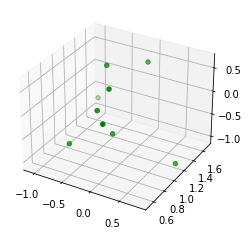

In [107]:
## 检查旋转前后边长不变

pos_batch = torch.rand(9, 3)
scale_batch=(torch.rand(9, 3)*3)
pos_batch = pos_batch*scale_batch

edge_index=torch.tensor([[0,0,0,0,1,1,1,2,2,3],
                        [1,2,3,4,2,3,4,3,4,4]])
row=pos_batch[edge_index[0]]
col=pos_batch[edge_index[1]]
radial=torch.norm(row-col, dim=1)
print(radial)
plot_3d(pos_batch)

rot_pos=torch.matmul(pos_batch,matrix)
row=rot_pos[edge_index[0]]
col=rot_pos[edge_index[1]]
radial=torch.norm(row-col, dim=1)
print(radial)
plot_3d(rot_pos)

In [117]:
from model.ignn import IGNN
import torch.nn as nn
from utils.graph_utils import get_edges_batch

device=torch.device("cuda:0")

params = {"device": device,
            "lr": 0.0,
            "num_nodes": 3,
            "in_node_attr_dim": 1,
            "node_attr_dim": 128,
            "out_node_attr_dim": 1,
            "egde_attr_dim": 1,
            "message_dim": 128,
            "global_layer_size": 64,
            "num_layers": 8,
            "activation": nn.SiLU(),
            "residual": True,
            "attention": True,
            "normalize": True,
            "tanh": False,
            "last_sigmoid": False}

ignn=IGNN(**params)

def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)

ignn.apply(weight_init)

def random_rotate(system_3d):
    quaternion = np.random.rand(4)
    quaternion /= np.linalg.norm(quaternion)
    r = R.from_quat(quaternion.tolist())
    matrix=r.as_matrix()
    matrix=torch.FloatTensor(matrix)
    system_3d=torch.matmul(system_3d,matrix)
    return system_3d

for i in range(10):
    pos_batch = torch.rand(9, 3)
    scale_batch=(torch.rand(9, 3)*3)
    pos_batch = pos_batch*scale_batch
    rot_pos=random_rotate(pos_batch)
    pos_batch=pos_batch.to(device)
    h = torch.ones(9, 1).to(device)
    edge_index, edge_attr = get_edges_batch(3, 3)
    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)
    a=ignn(pos_batch, h, edge_index, edge_attr)
    print(a)

    rot_pos=rot_pos.to(device)
    h = torch.ones(9, 1).to(device)
    edge_index, edge_attr = get_edges_batch(3, 3)
    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)

    a=ignn(rot_pos, h, edge_index, edge_attr)
    print(a)
    print("==================")


tensor([[0.0264],
        [0.0262],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0264],
        [0.0262],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0262],
        [0.0224],
        [0.0269]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0262],
        [0.0224],
        [0.0269]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0272],
        [0.0256],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0272],
        [0.0256],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0234],
        [0.0256],
        [0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0234],
        [0.0256],
        [0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0191],
        [0.0239],
        [0.0264]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0191],
        [0.0239],
        [0.0264]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0262],
  

## 验证 BFGS 的 Invariance

In [157]:
from bfgs_relax import relax,batch_relax

pos_batch = torch.rand(90, 3)
scale_batch=(torch.rand(90, 3)*3)
pos_batch = pos_batch*scale_batch
rot_pos=random_rotate(pos_batch)

pos_batch=pos_batch.view(3,30,3)
batch_steps,batch_energy=batch_relax(pos_batch,500,3)
print(batch_steps)
print(batch_energy)

rot_pos=rot_pos.view(3,30,3)
batch_steps,batch_energy=batch_relax(rot_pos,500,3)
print(batch_steps)
print(batch_energy)

KeyboardInterrupt: 